Simulator

In [23]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit import schedule as build_schedule
from qiskit_ibm_provider import IBMProvider
from qiskit import transpile, pulse, assemble
from qiskit_ibm_runtime.fake_provider import FakeHanoi, FakeCairo, FakeToronto, FakeWashington
from qiskit_aer.noise import NoiseModel
from qiskit.pulse.library import Gaussian
from qiskit.circuit.library import XGate, YGate 
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

In [27]:
# QASM from the benchmark

qasm_code = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3];
creg c[3];

x q[0];
x q[1];
h q[2];
cx q[1],q[2];
tdg q[2];
cx q[0],q[2];
t q[2];
cx q[1],q[2];
tdg q[2];
cx q[0],q[2];
tdg q[1];
t q[2];
cx q[0],q[1];
h q[2];
tdg q[1];
cx q[0],q[1];
t q[0];
s q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
"""

circuit = QuantumCircuit.from_qasm_str(qasm_code)

simulator = Aer.get_backend('qasm_simulator')
fake_backend = FakeCairo()

transpiled_circuit = transpile(circuit,fake_backend)

job_fake = fake_backend.run(transpiled_circuit,shots=1024)
result_fake = job_fake.result()
fake_counts = result_fake.get_counts()
print(fake_counts)

{'111': 951, '011': 29, '110': 17, '101': 16, '010': 4, '001': 6, '100': 1}


In [29]:
#run on simulator

job_sim = simulator.run(transpiled_circuit,shots=1024)
result_sim = job_sim.result()
ideal_counts = result_sim.get_counts()
print(ideal_counts)

{'111': 1024}


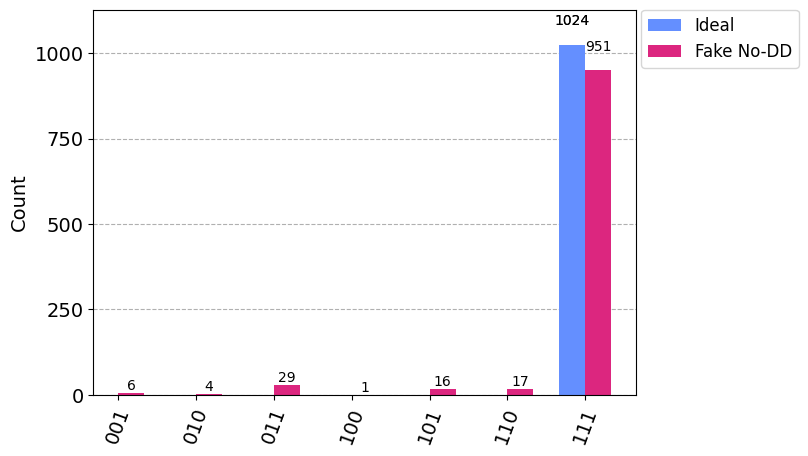

In [31]:
plot_histogram([ideal_counts,fake_counts],legend=['Ideal','Fake No-DD'])

In [32]:
#function to calculate fidelity

def calulate_fidelity(ideal_counts,experimental_counts):
    ideal_total = sum(ideal_counts.values())
    experimental_total = sum(experimental_counts.values())
    fidelity = sum(min(ideal_counts.get(key,0) / ideal_total, experimental_counts.get(key,0)/experimental_total)
                   for key in ideal_counts)
    return fidelity

fidelity_ideal = calulate_fidelity(ideal_counts,ideal_counts)
fidelity_fake = calulate_fidelity(ideal_counts,fake_counts)

print("Ideal Fidelity:", fidelity_ideal)
print("Fake No-DD Fidelity:", fidelity_fake)

Ideal Fidelity: 1.0
Fake No-DD Fidelity: 0.9287109375


#All-DD

h: 96 dt
x: 96 dt
y: 96 dt
t: 96 dt
s: 96 dt
tdg: 96 dt
reset: 10 dt
measure: 22400 dt
cx(1, 2): 2496.0 dt
cx(0, 2): 1440.0 dt
cx(0, 1): 1536.0 dt



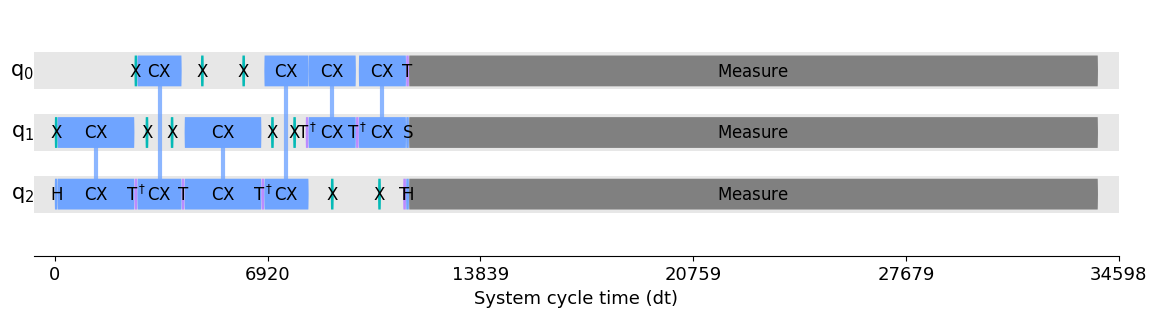

In [35]:
#회로에 cycle time 추가한걸로 보임

durations = InstructionDurations(
    [("cx", [1, 2], 2496.0),
    ("cx", [0, 2], 1440.0),
    ("cx", [0, 1], 1536.0),
    ("h", None, 96),
    ("x", None, 96),
    ("x", None, 96),
    ("y", None, 96),
    ("t", None, 96),
    ("s", None, 96),
    ("tdg", None, 96),
    ("reset", None, 10),
    ("measure", None, 22400)]
    )
print(durations)
    
# dd_sequence = [YGate(), YGate()]
dd_sequence = [XGate(), XGate()]
# dd_sequence = [XGate(), YGate(), XGate(), YGate()]
# dd_sequence = [XGate(), YGate(), XGate(), YGate(), XGate(), YGate(), XGate(), YGate()]
    
pm = PassManager([ALAPSchedule(durations), DynamicalDecoupling(durations, dd_sequence)])
circuit_all_dd = pm.run(circuit)
timeline_drawer(circuit_all_dd)

{'111': 1024}
{'111': 951, '011': 29, '110': 17, '101': 16, '010': 4, '001': 6, '100': 1}
{'111': 909, '001': 10, '101': 32, '110': 36, '100': 14, '011': 19, '010': 2, '000': 2}


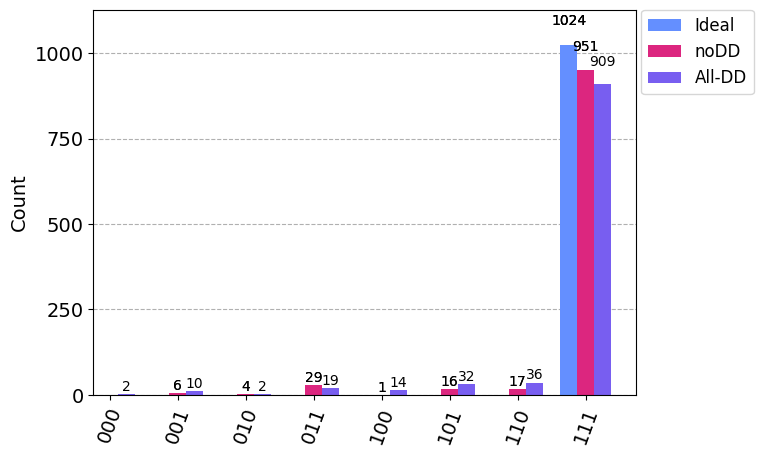

In [37]:
fake_backend_job = fake_backend.run(circuit_all_dd,shots=1024)
all_dd_counts = fake_backend_job.result().get_counts()

print(ideal_counts)
print(fake_counts)
print(all_dd_counts)

plot_histogram([ideal_counts,fake_counts,all_dd_counts],legend=['Ideal','noDD','All-DD'])

In [39]:
fidelity_all_dd = calulate_fidelity(ideal_counts,all_dd_counts)

print("Fidelity of Ideal:", fidelity_ideal),
print("Fidelity of Noisy Simulation:", fidelity_fake)
print("Fidelity with Dynamical Decoupling:", fidelity_all_dd)

Fidelity of Ideal: 1.0
Fidelity of Noisy Simulation: 0.9287109375
Fidelity with Dynamical Decoupling: 0.8876953125


#RL-DD

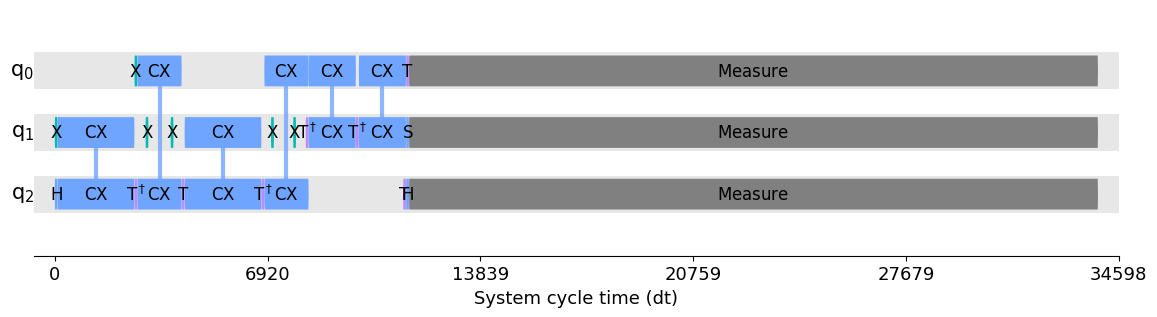

In [41]:
# dd_sequence = [YGate(), YGate()]
dd_sequence = [XGate(), XGate()]
# dd_sequence = [XGate(), YGate(), XGate(), YGate()]
# dd_sequence = [XGate(), YGate(), XGate(), YGate(), XGate(), YGate(), XGate(), YGate()]

pm = PassManager([ALAPSchedule(durations), DynamicalDecoupling(durations, dd_sequence, qubits=[1])])

circuit_dd = pm.run(circuit)
timeline_drawer(circuit_dd)
timeline_drawer(circuit_dd, filename='toffoli_fake_all_rl_dd.png')

{'111': 1024}
{'111': 951, '011': 29, '110': 17, '101': 16, '010': 4, '001': 6, '100': 1}
{'111': 885, '110': 50, '100': 26, '101': 35, '011': 20, '001': 3, '010': 5}


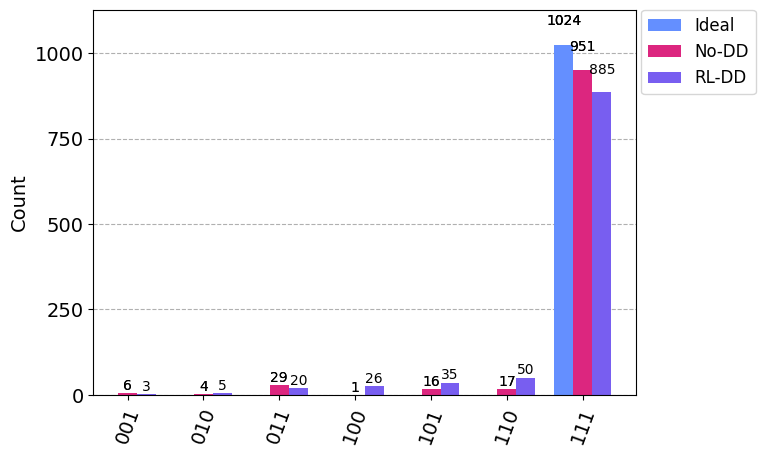

In [42]:
fake_backend_job = fake_backend.run(circuit_dd, shots=1024)
rl_dd_counts = fake_backend_job.result().get_counts()

print(ideal_counts)
print(fake_counts)
print(rl_dd_counts)

plot_histogram([ideal_counts, fake_counts, rl_dd_counts], legend=['Ideal','No-DD','RL-DD'])

In [43]:
fidelity_rl_dd = calulate_fidelity(ideal_counts,rl_dd_counts)

print("Fidelity of Ideal: ", fidelity_ideal)
print("Fidelity of Noisy Simulation: ", fidelity_fake)
print("Fidelity with Dynamical Decoupling: ", fidelity_rl_dd)

Fidelity of Ideal:  1.0
Fidelity of Noisy Simulation:  0.9287109375
Fidelity with Dynamical Decoupling:  0.8642578125


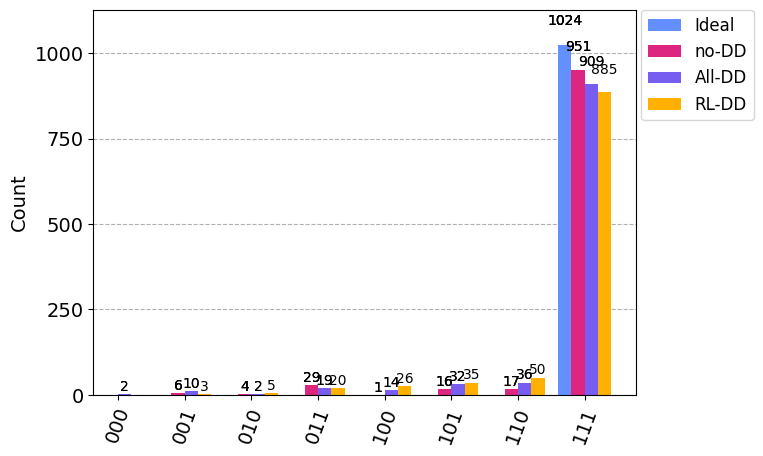

In [44]:
plot_histogram([ideal_counts,fake_counts,all_dd_counts,rl_dd_counts],legend=["Ideal","no-DD","All-DD","RL-DD"])

In [45]:
# Fidelity
print("Ideal fFidelity:", fidelity_ideal)
print("No-DD fidelity:", fidelity_fake)
print("All-DD fidelity:", fidelity_all_dd)
print("RL-DD fidelity:", fidelity_rl_dd)

Ideal fFidelity: 1.0
No-DD fidelity: 0.9287109375
All-DD fidelity: 0.8876953125
RL-DD fidelity: 0.8642578125


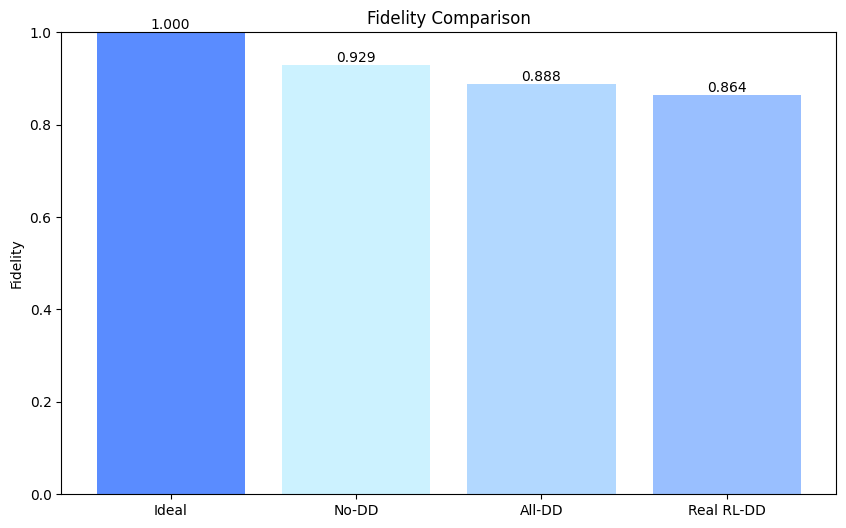

In [46]:
import matplotlib.pyplot as plt

# Data
labels = ['Ideal', 'No-DD', 'All-DD', 'Real RL-DD']
values =[fidelity_ideal, fidelity_fake, fidelity_all_dd, fidelity_rl_dd]
colors = ['#2366ff', '#bbeeff', '#99ccff', '#77aaff']

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors, alpha=0.75)

# Add a title and labels
plt.title('Fidelity Comparison')
plt.ylabel('Fidelity')
plt.ylim(0.00, 1.00)  # Set y-axis limits to zoom in on differences

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.3f}", ha='center', va='bottom', fontsize=10)
    
# Display the plot
plt.show()